In [ ]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.12.0
Running on TPU  ['10.17.57.146:8470']


In [ ]:
!pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 1.8 MB/s eta 0:00:00


In [ ]:
import patoolib

In [ ]:
patoolib.extract_archive('/archive (2) (1).zip')

patool: Extracting /archive (2) (1).zip ...
patool: running /usr/bin/7z x -o./Unpack_6m5n40v4 -- "/archive (2) (1).zip"
patool: ... /archive (2) (1).zip extracted to `archive (2) (1)' (multiple files in root).


'archive (2) (1)'

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
import random
import keras
import tensorflow
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.preprocessing import image as k_image
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop
from keras.layers import PReLU
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tqdm import tqdm
from sklearn.cluster import KMeans
import gc
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

# Project 2: Using Unsupervised and Deep Learning Methods to Predict Pet Emotions from Facial Images

## Project Topic

The goal of this project is to use unsupervised learning and deep learning methods to predict and classify pet emotions from images of their facial expressions. For this project, I will be utilizing a dataset of 1000 facial images of various pets (dogs, cats, hamsters, etc.) with differing expressions (classified as angry, happy, sad, or other). I plan to use a k-means clustering approach using the image data initially, as a way to implement an unsupervised learning algorithm, to try to cluster the different emotions of pet images together. I will then compare my results from this unsupervised learning method with a Convolutional Neural Network (CNN) and its predictive power to identify these images and the different emotions displayed by pets. Hyperparameter tuning and optimization will take place for both methods in an effort to maximize predictive accuracy. The motivation behind this project is to apply machine learning methods learned in class to a real dataset. The specific task at hand will not only help accomplish this goal, but may also assist in the study of facial recognition for pets and the advancement of animal well-being through identification of their emotional states.

## Data Description

The dataset used in this project, titled "pets facial expression dataset," is a compilation of 1000 high-quality face images showcasing various pets like dogs, cats, rabbits, hamsters, sheep, horses, and birds. Available on Kaggle (https://www.kaggle.com/datasets/anshtanwar/pets-facial-expression-dataset), and uploaded by user Ansh Tanwar, the images within the dataset capture a diverse range of expressions such as happiness, sadness, anger, curiosity, and surprise. The collection methodology involves the use of Pexels and Unsplash APIs, with images being processed, cropped, and segmented manually using Python scripts. The data is further divided into 250 images each labeled as happy, sad, angry, or other for training, and segregated testing and validation sets with 6-11 images in both test and validation sets for each emotion. The images are not uniform in size and range from less than 15 kilobytes to close to 30 kilobytes - all are in .jpg format.

Citation: Tanwar, Ansh. "Pets Facial Expression Dataset." Kaggle, dataset, 2023, https://www.kaggle.com/datasets/anshtanwar/pets-facial-expression-dataset.

## Data Cleaning and EDA

### Class Balance Verification

The description of the dataset in Kaggle details that there are 250 images for each emotion (angry, happy, sad, or other) in the training data, so we know that our classes are perfectly balanced for training. Below is a code snippet that prints out the number of images for each emotion identified within the testing, training, and validation sets:

In [ ]:

# Define the emotions and the main folders
emotion_folders = ['happy', 'Sad', 'Angry', 'Other']
main_folders = ['test', 'train', 'valid']

# Base path to the master folder
base_path = '/content/archive (2) (1)/Master Folder'

# Iterate through the main folders (test, train, valid)
for folder in main_folders:
    print(f"In the {folder} folder:")

    # Iterate through the emotion subfolders
    for emotion in emotion_folders:
        # Construct the path to the subfolder
        subfolder_path = os.path.join(base_path, folder, emotion)

        # Get a list of all files in the subfolder
        files = [f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))]

        # Print the number of files (images) in the subfolder
        print(f"Number of images in {emotion}: {len(files)}")
    print()  # Print a blank line between main folders

In the test folder:
Number of images in happy: 11
Number of images in Sad: 11
Number of images in Angry: 10
Number of images in Other: 6

In the train folder:
Number of images in happy: 250
Number of images in Sad: 250
Number of images in Angry: 250
Number of images in Other: 250

In the valid folder:
Number of images in happy: 11
Number of images in Sad: 10
Number of images in Angry: 9
Number of images in Other: 6



### Image Re-sizing

We can see above that our training data is perfectly balanced, and our testing and validation sets will only be used to evaluate our models, and thus they do not need to be re-balanced. However, the dimensions of the images may not be uniform, which would pose a potential problem for subsequent analysis. Below, we load in the images and plot their dimensions for each emotion within each of the training, testing, and validation sets.

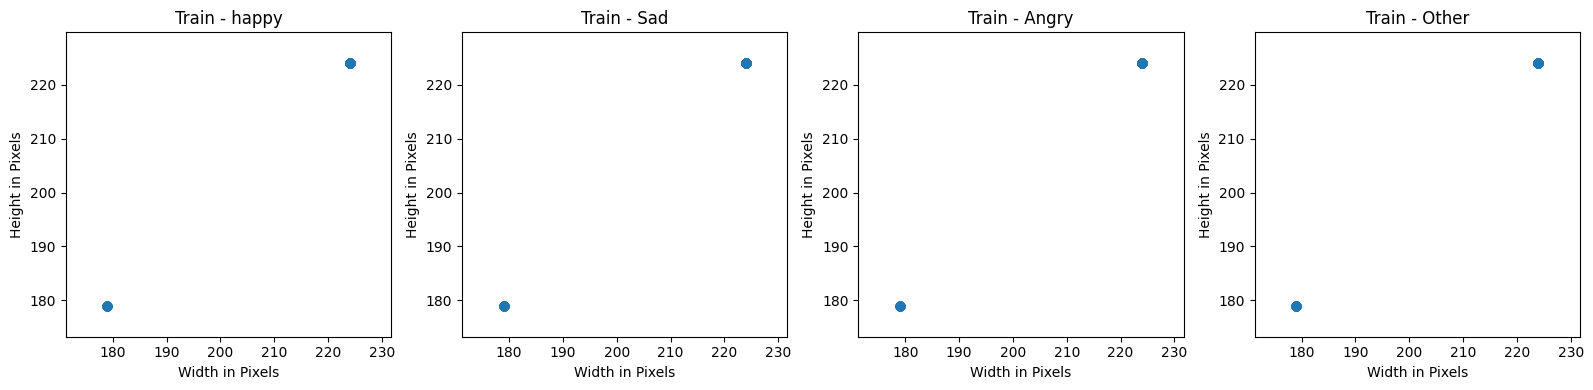

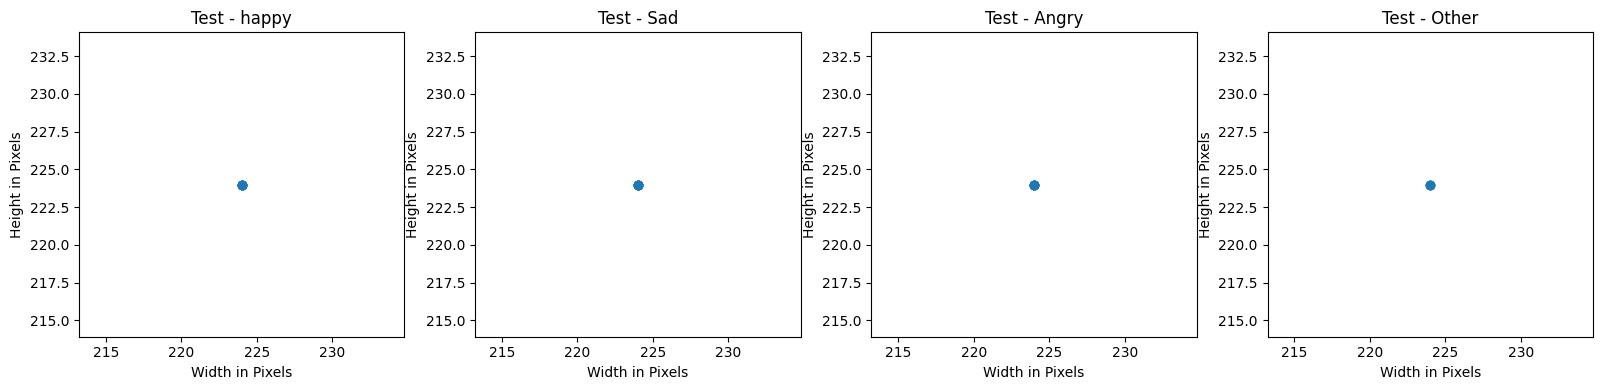

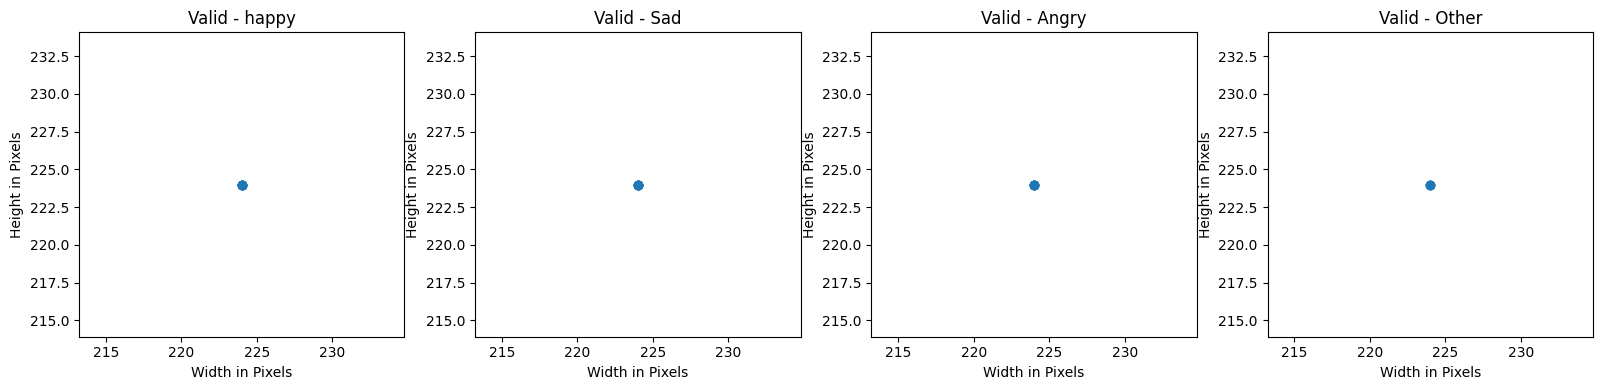

In [ ]:
def load_images(folder_path):
    dimensions = []
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        if os.path.isfile(filepath):
            try:
                img = Image.open(filepath)
                dimensions.append(img.size)
            except:
                pass
    return dimensions

def plot_scatter(dimensions, title):
    if not dimensions:
        return

    plt.scatter(widths, heights, alpha=0.6)
    plt.xlabel('Width in Pixels')
    plt.ylabel('Height in Pixels')
    plt.title(title)
    plt.axis('equal')

# Path to the master folder
master_folder_path = base_path

# List the subfolders (train, test, valid)
subfolders = ['train', 'test', 'valid']

# Emotions
emotion_folders = ['happy', 'Sad', 'Angry', 'Other']

# Number of plots per row
plots_per_row = 4

# Plot size
plot_size = 4

# Iterate through the subfolders
for subfolder in subfolders:
    plt.figure(figsize=(plot_size * plots_per_row, plot_size))

    for i, emotion in enumerate(emotion_folders):
        emotion_folder_path = os.path.join(master_folder_path, subfolder, emotion)
        dimensions = load_images(emotion_folder_path)
        widths, heights = zip(*dimensions) if dimensions else ([], [])

        plt.subplot(1, plots_per_row, i + 1)
        plot_scatter(dimensions, f'{subfolder.capitalize()} - {emotion}')

    plt.tight_layout()
    plt.show()

For testing and validation sets, all images are of uniform size. However, it appears we have two different sizes of images for all of our training sets. Below, we resize all the images in the training sets using a resampling filter to be the same size as all of the images in the testing/validation sets:

In [ ]:
def get_target_size(folder_path):
    for emotion in emotion_folders:
        for filename in os.listdir(os.path.join(folder_path, emotion)):
            filepath = os.path.join(folder_path, emotion, filename)
            if os.path.isfile(filepath):
                with Image.open(filepath) as img:
                    return img.size

def resize_images(folder_path, target_size):
    for emotion in emotion_folders:
        emotion_folder_path = os.path.join(folder_path, emotion)
        for filename in os.listdir(emotion_folder_path):
            filepath = os.path.join(emotion_folder_path, filename)
            if os.path.isfile(filepath):
                with Image.open(filepath) as img:
                    resized_img = img.resize(target_size, Image.LANCZOS)
                    resized_img.save(filepath)

# Path to the master folder
master_folder_path = base_path

# Emotions
emotion_folders = ['happy', 'Sad', 'Angry', 'Other']

# Get target size from the first image in the test folder
test_folder_path = os.path.join(master_folder_path, 'test')
target_size = get_target_size(test_folder_path)

# Resize all images in the training folder to the target size
train_folder_path = os.path.join(master_folder_path, 'train')
resize_images(train_folder_path, target_size)

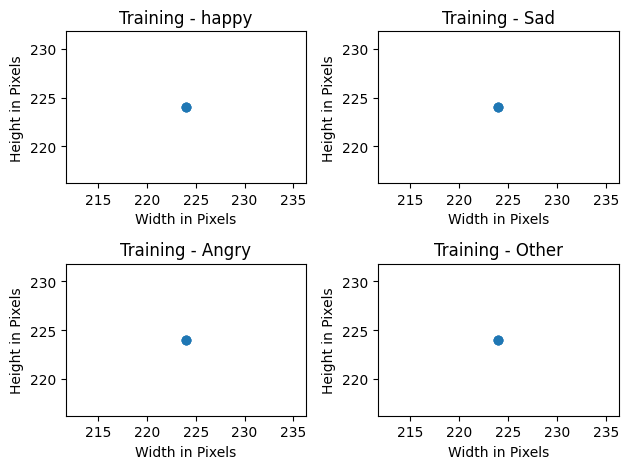

In [ ]:
# Plot size
plot_size = 4

# Iterate through the emotions and create scatter plots
for i, emotion in enumerate(emotion_folders):
    emotion_folder_path = os.path.join(train_folder_path, emotion)
    dimensions = load_images(emotion_folder_path)

    plt.subplot(2, 2, i + 1)
    plot_scatter(dimensions, f'Training - {emotion}')

plt.tight_layout()
plt.show()

All of our images are now of uniform size (224 x 224 pixels), as can be seen in the scatterplots above. This will assist us in our subsequent model-generation.

### Image Scaling/Normalization

It will assist our further processing methods to create normalized versions of all of the images, where pixel values are scaled to values from 0 - 1. Below, we create a dictionary of all images and normalize the pixel color values:

In [ ]:
# Dictionary to hold the normalized images for each subfolder
normalized_images_dict = {folder: {emotion: [] for emotion in emotion_folders} for folder in main_folders}

# Iterate through the main folders (test, train, valid)
for folder in main_folders:
    for emotion in emotion_folders:
        # Construct the path to the subfolder
        subfolder_path = os.path.join(base_path, folder, emotion)

        # Iterate through the image files in the subfolder
        for filename in os.listdir(subfolder_path):
            if filename.endswith(".jpg"):  # Assuming images are in jpg format
                filepath = os.path.join(subfolder_path, filename)

                # Read the image (in BGR format)
                image = cv2.imread(filepath)

                # Convert the image from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Normalize the pixel values to the [0, 1] range
                normalized_image = image / 255.0

                # Add the normalized image to the appropriate list
                normalized_images_dict[folder][emotion].append(normalized_image)

# Convert the lists to NumPy arrays and print the shapes
for folder in main_folders:
    for emotion in emotion_folders:
        normalized_images_dict[folder][emotion] = np.array(normalized_images_dict[folder][emotion])
        print(f"Shape of the normalized images array for {folder}/{emotion}: {normalized_images_dict[folder][emotion].shape}")

Shape of the normalized images array for test/happy: (11, 224, 224, 3)
Shape of the normalized images array for test/Sad: (11, 224, 224, 3)
Shape of the normalized images array for test/Angry: (10, 224, 224, 3)
Shape of the normalized images array for test/Other: (6, 224, 224, 3)
Shape of the normalized images array for train/happy: (250, 224, 224, 3)
Shape of the normalized images array for train/Sad: (250, 224, 224, 3)
Shape of the normalized images array for train/Angry: (250, 224, 224, 3)
Shape of the normalized images array for train/Other: (250, 224, 224, 3)
Shape of the normalized images array for valid/happy: (11, 224, 224, 3)
Shape of the normalized images array for valid/Sad: (10, 224, 224, 3)
Shape of the normalized images array for valid/Angry: (9, 224, 224, 3)
Shape of the normalized images array for valid/Other: (6, 224, 224, 3)


The shape of each array of normalized images is printed above for our reference, giving the number of images, the number of pixels in length and width (224 each for all images), and the three color values. Below we print out the first image in the train/happy image array to verify all pixel values are between 0 and 1:

In [ ]:
# Get the first normalized image in the 'train/happy' subfolder
first_normalized_image = normalized_images_dict['train']['happy'][0]

# Print the image matrix
print("First normalized image matrix in 'train/happy' subfolder:")
print(first_normalized_image)

First normalized image matrix in 'train/happy' subfolder:
[[[0.42352941 0.21960784 0.16470588]
  [0.41960784 0.22745098 0.16862745]
  [0.42745098 0.23529412 0.16862745]
  ...
  [0.11372549 0.20392157 0.1254902 ]
  [0.12941176 0.21960784 0.14117647]
  [0.14509804 0.23529412 0.15686275]]

 [[0.42352941 0.21960784 0.16470588]
  [0.41960784 0.22745098 0.16862745]
  [0.41960784 0.23529412 0.16470588]
  ...
  [0.10980392 0.2        0.12156863]
  [0.12941176 0.21960784 0.14117647]
  [0.14509804 0.23529412 0.15686275]]

 [[0.41176471 0.21960784 0.16078431]
  [0.41176471 0.21960784 0.16078431]
  [0.40784314 0.22352941 0.15294118]
  ...
  [0.10196078 0.19215686 0.11372549]
  [0.1254902  0.21568627 0.1372549 ]
  [0.14117647 0.23137255 0.15294118]]

 ...

 [[0.74117647 0.66666667 0.54901961]
  [0.74901961 0.6745098  0.55686275]
  [0.75686275 0.68235294 0.56470588]
  ...
  [0.21960784 0.25098039 0.19215686]
  [0.19607843 0.22745098 0.17647059]
  [0.18039216 0.21176471 0.16078431]]

 [[0.74117647 0.

### Image Visual Inspection

Finally, we can display some random images from the dataset to get a better idea of the kinds of images we are dealing with, and to explore the data further. Below is a code snippet that prints out 15 random images along with their designated emotion label.

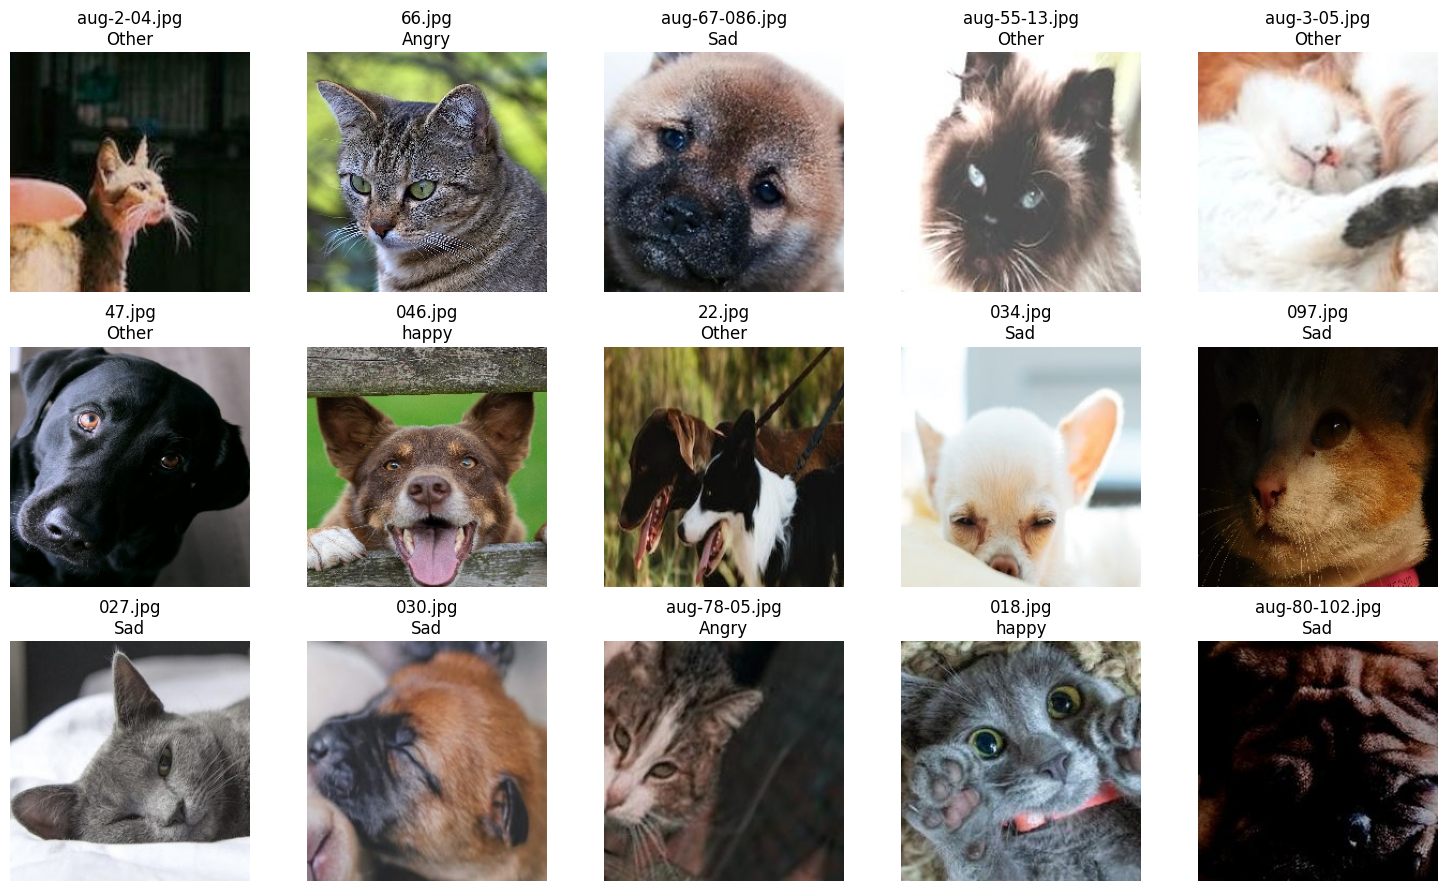

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
displayed_images = set() # To keep track of the images we've already displayed

for ax in axes.flat:
    folder, emotion, image_index = None, None, None

    # Ensure that the selected image has not been displayed before
    while True:
        folder = random.choice(main_folders)
        emotion = random.choice(emotion_folders)
        image_index = random.randint(0, len(normalized_images_dict[folder][emotion]) - 1)

        unique_key = (folder, emotion, image_index)
        if unique_key not in displayed_images:
            displayed_images.add(unique_key)
            break

    image = normalized_images_dict[folder][emotion][image_index]
    filename = os.listdir(os.path.join(base_path, folder, emotion))[image_index]

    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"{filename}\n{emotion}")

plt.tight_layout()
plt.show()

We can identify immediately that a variety of animals are shown. This could pose problems for our learning methods, as a happy cat may look quite different from a happy dog, for example. We can see a large range in colors as well, as the backgrounds of each photo are quite varied. This may also be problematic.

### EDA Conclusions/Discussions and Strategy for Further Analysis

My EDA and Preprocessing of the data was conducted with the following steps:

- Class Balance Verification: Ensuring that all classes of emotions (happy, sad, angry, other) are equally represented in the training dataset, providing a balanced foundation for modeling.

- Image Resizing: Standardizing all images to a uniform size of 224 x 224 pixels, allowing for consistent input to machine learning models.

- Image Normalization: Normalizing the image pixel values to the [0,1] range, which typically speeds up convergence and can lead to better results.

- Visual Inspection: Performing a visual inspection on a set of random images to gain an understanding of the data.

My initial conclusions after performing these steps are as follows:

- The EDA steps have prepared a clean and consistent dataset that is ready for modeling. It was beneficial that the author of the dataset already segregated the data nicely into training, testing, and validation sets.

- The dataset includes a wide range of colors and different animal faces, indicating a complex and diverse set of data.

- The data's visual nature and complexity make it ideal for deep learning methods like CNN, which excel at capturing intricate patterns in image data.

The following factors could present with potential difficulties going forward:

- Animal Diversity: With many different animals present in the dataset, the models will need to generalize across various species, potentially increasing the complexity of the classification task.

- Color Variation: The large range of colors might pose a challenge as different shades and hues might represent the same emotion differently across different animals.

- Complex Emotion Recognition: Detecting subtle differences between emotions like "happy" and "sad" could be intricate, especially when considering the different ways animals might express these emotions.

My analysis strategy going forward:

- K-means Clustering with Transfer Learning: I will be utilizing pre-trained models to extract features followed by K-means clustering to try to initially categorize the images into groups and will test the accuracy of said model.

- Convolutional Neural Network (CNN) Modeling: Developing a CNN deep learning model will likely be a powerful approach for classifying these images based on their emotions. Fine-tuning the architecture and selecting appropriate hyperparameters will be key to achieving good performance.

- Continuous Monitoring, Validation, and Hyperparameter Optimization: Given the complexities of the dataset, it will be vital to continuously validate the models' performances on unseen data, possibly requiring further tuning or adjustments to the model over time, as well as rigorous hyperparameter tuning.

I may also need to perform further preprocessing as needed, which will be done where I create the models below.

## Model Approach Decisions and Further Preprocessing

### Model Approach 1: K-means Clustering with Extracted Features from Transfer Learning

Our first approach is to construct a K-means model that will try to group the images together into four different clusters, one for each emotion, to see if an unsupervised learning algorithm can identify the emotions in our dataset.

However, clustering based only upon pixel values would be extremely computationally expensive, considering that our image sizes are 224 x 224 pixels, thus giving us a 49728-vector for each image. To avoid this problem, we will first attempt feature extraction using a pre-trained deep learning model from https://keras.io/api/applications/.

Utilizing a k-means clustering approach to cluster images by emotions, coupled with transfer learning techniques for feature extraction, presents several compelling advantages. Transfer learning leverages pre-trained models like MobileNet, which have already been trained on extensive datasets, to extract complex and high-level features from the images. These features are often more discriminative and robust compared to those obtained by a shallow or domain-specific model. By using these features, k-means can cluster the images into groups representing underlying patterns or emotions without needing labeled data, making it an unsupervised learning method. This ability to find structure without manual labeling can save significant time and effort. Moreover, the combination of transfer learning with k-means allows for a more interpretable analysis of the dataset by grouping similar images together, aiding in the understanding of the emotional content within the data. Additionally, the k-means algorithm is relatively simple and computationally efficient, making it accessible for large datasets. Together, these attributes make the k-means clustering approach with transfer learning a powerful option for our analysis, particularly when attempting to discover hidden relationships and patterns in complex image datasets like those representing emotions.

Our first attempt will use the MobileNet model for feature extraction, as something of a baseline model that is not overly computationally expensive. After inserting this model into a K-means clustering algorithm, we can evaluate how well our images have been properly clustered into the correct emotions, and perhaps try more robust pre-trained models to re-run a K-means clustering.

MobileNet is a streamlined and efficient deep learning architecture designed specifically for mobile and embedded vision applications. It is built on depthwise separable convolutions, which split the standard convolution operation into a depthwise convolution followed by a pointwise convolution. This division reduces the computational complexity without a significant loss in accuracy, allowing the model to run on devices with limited computational resources. When it comes to feature extraction, MobileNet's architecture is able to capture essential information about an image's content through its multiple layers of convolutions and activations. The resulting feature vectors can effectively describe the underlying patterns and structures within the images, encapsulating information about shapes, textures, and objects. By using MobileNet for feature extraction, the high-dimensional raw image data is transformed into a more manageable and meaningful representation. This condensed feature set is particularly useful for k-means clustering, as it enables the clustering algorithm to identify and group similar images based on the extracted features. In other words, MobileNet helps translate raw pixel values into a form where k-means can more easily discern the inherent clusters, making it an effective pre-processing step for image clustering tasks.

####_Deep Learning Feature Extraction for K-means via MobileNet_

Below, we build a model for feature extraction and then extract features from all of the normalized data in the training sets:

In [ ]:
# Create the MobileNet model, excluding the top layer
base_model = MobileNet(weights='imagenet', include_top=False)

# Prepare a list to hold the extracted features
extracted_features = []

# Iterate through the main folders (test, train, valid)
for folder in ['train']:
    for emotion in emotion_folders:
        images = normalized_images_dict[folder][emotion]
        for image in images:
            # Ensure the image is the correct shape for MobileNet
            #image = cv2.resize(image, (224, 224))

            # Expand dimensions to match the shape MobileNet expects
            image = np.expand_dims(image, axis=0)

            # Extract the features using MobileNet
            features = base_model.predict(image)


            # Append the features to the list
            extracted_features.append(features)


extracted_features_array = np.array(extracted_features)

# Check the shape to make sure everything looks correct
print('Extracted features shape:', extracted_features_array.shape)

1/1 [==============================] - 0s 45ms/step
Extracted features shape: (1000, 1, 7, 7, 1024)


Above, features are extracted for the training data, and the shape of the extracted features array has been printed: (1000, 1, 7, 7, 1024).

Below, we do the same for testing and validation sets:

In [ ]:
# Prepare a list to hold the extracted features
extracted_features_test = []

# Iterate through the main folders (test, train, valid)
for folder in ['test']:
    for emotion in emotion_folders:
        images = normalized_images_dict[folder][emotion]
        for image in images:
            # Ensure the image is the correct shape for MobileNet
            #image = cv2.resize(image, (224, 224))

            # Expand dimensions to match the shape MobileNet expects
            image = np.expand_dims(image, axis=0)

            # Extract the features using MobileNet
            features = base_model.predict(image)


            # Append the features to the list
            extracted_features_test.append(features)


extracted_features_test_array = np.array(extracted_features_test)

# Check the shape to make sure everything looks correct
print('Extracted features shape, test data:', extracted_features_test_array.shape)

1/1 [==============================] - 0s 48ms/step
Extracted features shape, test data: (38, 1, 7, 7, 1024)


In [100]:
# Prepare a list to hold the extracted features
extracted_features_valid = []

# Iterate through the main folders (test, train, valid)
for folder in ['valid']:
    for emotion in emotion_folders:
        images = normalized_images_dict[folder][emotion]
        for image in images:
            # Ensure the image is the correct shape for MobileNet
            #image = cv2.resize(image, (224, 224))

            # Expand dimensions to match the shape MobileNet expects
            image = np.expand_dims(image, axis=0)

            # Extract the features using MobileNet
            features = base_model.predict(image)


            # Append the features to the list
            extracted_features_valid.append(features)


extracted_features_valid_array = np.array(extracted_features_valid)

# Check the shape to make sure everything looks correct
print('Extracted features shape, validation data: ', extracted_features_valid_array.shape)

1/1 [==============================] - 0s 49ms/step
Extracted features shape, validation data:  (36, 1, 7, 7, 1024)


### Model Approach 2: Custom Convolutional Neural Network

Our second approach will be to build a custom CNN trained only on our training data. Through hyperparameter tuning and optimization, we will subsequently determine the proper convolution techniques and interim layers, and our output of our CNN will be a softmax layer that will produce a probability distribution across the possible class labels for our input data, and will automatically determine which emotion label a given image belongs to based on the most probable prediction.

Building a custom Convolutional Neural Network (CNN) specifically for the given image dataset has several advantages over relying on a pre-trained neural network such as those available in Keras. Firstly, a custom CNN can be tailored to the unique characteristics and requirements of the particular dataset, allowing for optimization of architecture and hyperparameters that align with the specific task. This can lead to better performance, as the network is designed to understand the nuances of the data rather than general patterns across various datasets. Secondly, pre-trained models are often substantial and complex, designed for a broad range of tasks, which may lead to unnecessary complexity and resource consumption for a specialized task. Lastly, the training of a custom model on the specific dataset ensures that the model learns features that are truly representative of the data in question, without biases introduced by irrelevant training samples. This focused approach often results in a more interpretable and efficient model that is closely aligned with the task at hand.

In our EDA and Preprocessing steps, we have already normalized the image data, ensured a constant size for all images. The training, testing, and validation steps have all already been created by the dataset author. If further preprocessing is needed, such as cropping or changing the colors of the images to grayscale, this can be done as part of hyperparameter tuning of the model. All further steps to build, train, and evaluate this model will be conducted below in the Model Training/Hyperparameter Tuning section below.


## Model Building, Training, Tuning, and Optimization

### Model Approach 1: K-Means Clustering

#### _Baseline Model Building and Training_

Below, we build a baseline k-means model from the extracted feature data of the training set of images. This is a baseline model with no hyperparameter tuning or optimization, only with a specified n = 4, to create four different clusters that hopefully correspond with our emotions.

In [109]:
# Convert the list of features to a NumPy array
extracted_features_array = np.array(extracted_features)

# Flatten the features
flattened_features = extracted_features_array.reshape(extracted_features_array.shape[0], -1)

# Create a k-means model with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)

# Fit the model to your features
kmeans.fit(flattened_features)

# The cluster centers (if needed)
cluster_centers = kmeans.cluster_centers_

# The labels of the clusters
labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### _Initial Evaluation on Training Data_

Because K-means clustering is an unsupervised learning algorithm, it merely allocates data points to four different clusters that we knew to specify beforehand - we only hope that this algorithm groups the data points in the appropriate manner, finding similar characteristics that hopefully are apparently different for each emotion. We do not tell the algorithm before running it the characteristics that separate one emotion from another, nor do we know them ourselves. Because of this, although we can use the original emotion labels to evaluate how well the algorithm classified the results based upon our dividing criteria, we cannot generate an accuracy score or confusion matrix for these clusters. Below, we evaluate our baseline model as best we can. First, we generate a bar chart showing the number of images that have been assigned to each of our four clusters, and print out the number of images per cluster:

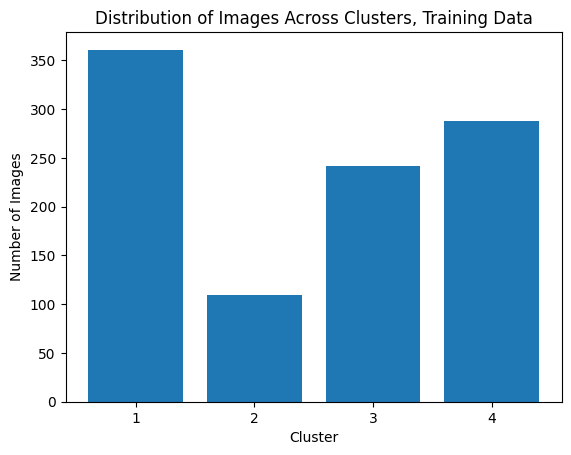

Cluster 3: 242 images
Cluster 1: 361 images
Cluster 2: 109 images
Cluster 4: 288 images


In [110]:
plt.hist(labels, bins=range(5), align='left', rwidth=0.8)
plt.xlabel('Cluster')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Clusters, Training Data')
plt.xticks(range(4), [str(i+1) for i in range(4)])  # Adjust the x-axis labels
plt.show()

# Count the occurrences of each label
label_counts = Counter(labels)

# Print the counts for each cluster
for cluster, count in label_counts.items():
    print(f"Cluster {cluster + 1}: {count} images")

We can see that, although clusters 3 and 4 have data points reasonably close to 250 (the real number of images in each category), cluster 1 was overassigned over 100 data points while cluster 2 was underassigned over 100 data points, which is erroneous.

Below, we generate a pie chart for each cluster that shows the percentage within each cluster of images based on their original emotion label:

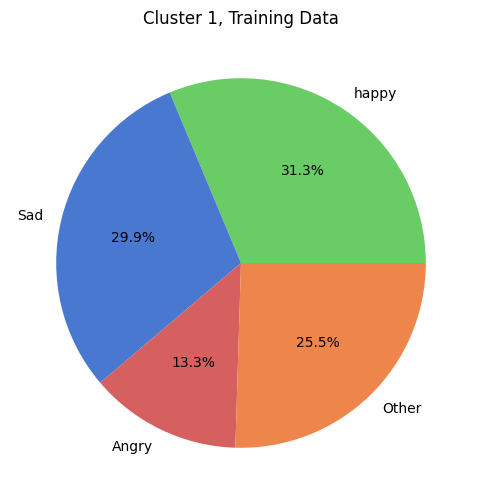

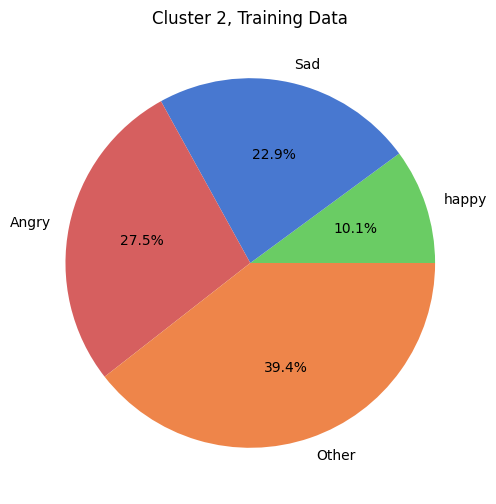

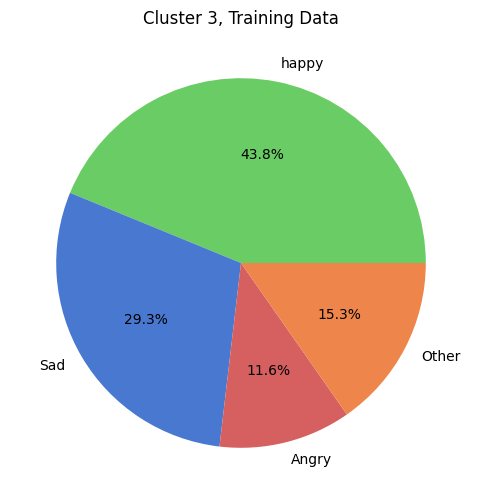

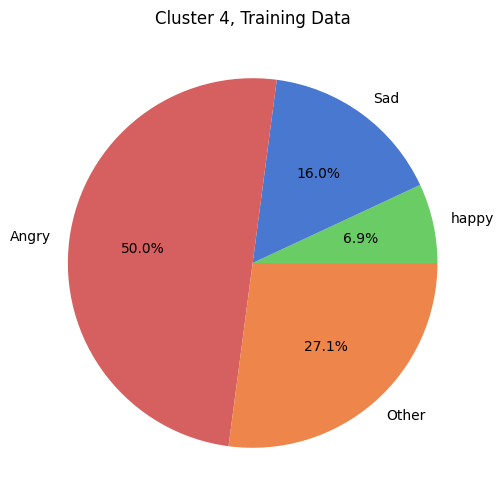

In [111]:

# Mapping original emotion labels
original_emotion_labels = []
for emotion in emotion_folders:
    original_emotion_labels.extend([emotion] * len(normalized_images_dict['train'][emotion]))

# Create a color palette with seaborn
palette = sns.color_palette("muted")

# Map the colors to the emotions
color_map = {
    'happy': palette[2], # Green
    'Sad': palette[0], # Blue
    'Angry': palette[3], # Red
    'Other': palette[1] # Orange
}

# Create a list to hold the emotion count for each cluster
clusters_data = [Counter() for _ in range(4)] # Assuming 4 clusters

# Count the emotions for each cluster using the cluster labels and original emotion labels
for cluster_label, original_emotion in zip(labels, original_emotion_labels):
    clusters_data[cluster_label][original_emotion] += 1


# Pie graphs
for i, cluster in enumerate(clusters_data):
    plt.figure(figsize=(6, 6))
    emotions, counts = zip(*cluster.items())
    colors = [color_map[e] for e in emotions]
    plt.pie(counts, labels=emotions, colors=colors, autopct='%1.1f%%')
    plt.title(f'Cluster {i + 1}, Training Data') # Adjust the cluster number here
    plt.show()

We can see above that no cluster shows a majority of data points as belonging to a single emotion (cluster 4 is the closest with 50% of its data belonging to "angry"). We do not expect much improved results on either the validation or testing sets, which we perform the same analysis and visualizations on below:

#### _Initial Evaluation on Validation Data_

In [ ]:
flattened_features_valid = extracted_features_valid_array.reshape(extracted_features_valid_array.shape[0], -1)

# Predict the clusters for validation data
validation_labels = kmeans.predict(flattened_features_valid)

flattened_features_test = extracted_features_test_array.reshape(extracted_features_test_array.shape[0], -1)

# Predict the clusters for test data
test_labels = kmeans.predict(flattened_features_test)

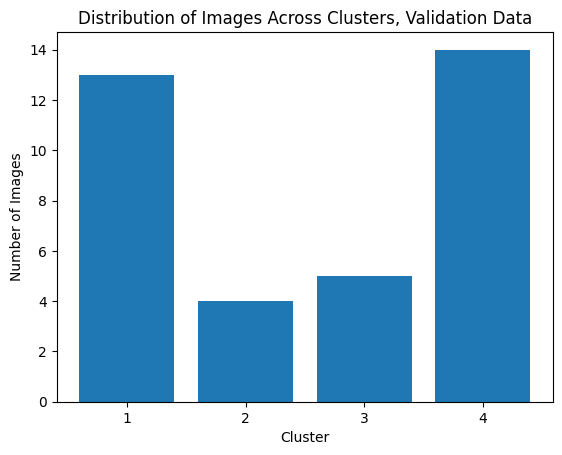

Cluster 1: 13 images
Cluster 3: 5 images
Cluster 4: 14 images
Cluster 2: 4 images


In [ ]:
plt.hist(validation_labels, bins=range(5), align='left', rwidth=0.8)
plt.xlabel('Cluster')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Clusters, Validation Data')
plt.xticks(range(4), [str(i+1) for i in range(4)])  # Adjust the x-axis labels
plt.show()

# Count the occurrences of each label in the validation set
validation_label_counts = Counter(validation_labels)

# Print the counts for each cluster
for cluster, count in validation_label_counts.items():
    print(f"Cluster {cluster + 1}: {count} images")


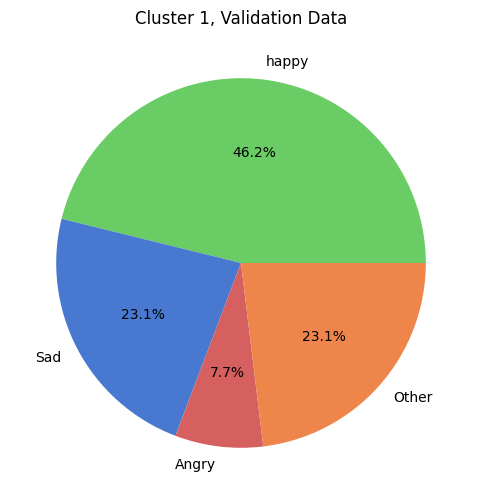

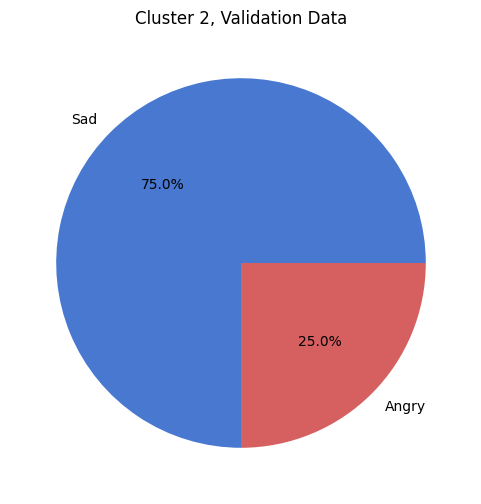

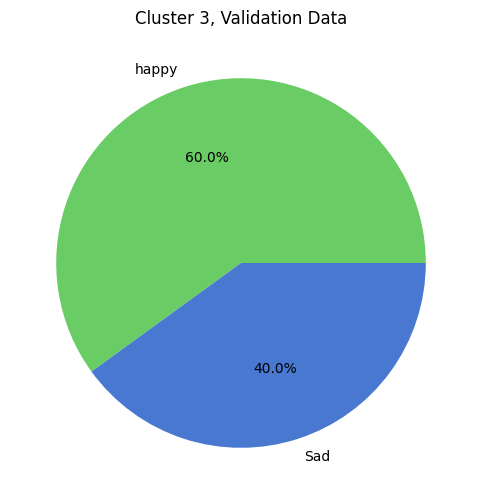

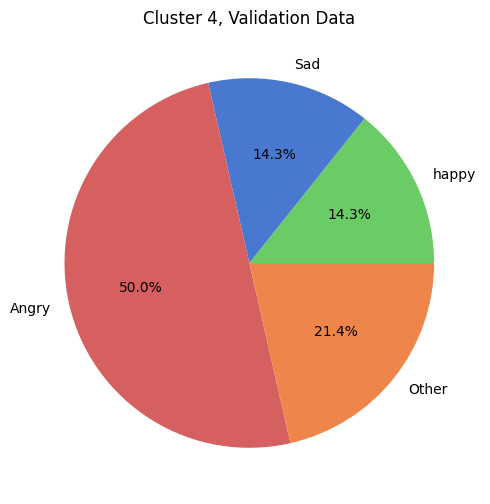

In [ ]:
# Assuming you have the original emotion labels for the validation set
original_emotion_labels_validation = []
for emotion in emotion_folders:
    original_emotion_labels_validation.extend([emotion] * len(normalized_images_dict['valid'][emotion]))

# Assuming the labels for the validation set have been obtained
validation_labels = kmeans.predict(extracted_features_valid_array.reshape(extracted_features_valid_array.shape[0], -1))

# Create a list to hold the emotion count for each validation cluster
validation_clusters_data = [Counter() for _ in range(4)] # Assuming 4 clusters

# Count the emotions for each validation cluster using the validation cluster labels and original validation emotion labels
for cluster_label, original_emotion in zip(validation_labels, original_emotion_labels_validation):
    validation_clusters_data[cluster_label][original_emotion] += 1

# Pie graphs for validation data
for i, cluster in enumerate(validation_clusters_data):
    plt.figure(figsize=(6, 6))
    emotions, counts = zip(*cluster.items())
    colors = [color_map[e] for e in emotions]
    plt.pie(counts, labels=emotions, colors=colors, autopct='%1.1f%%')
    plt.title(f'Cluster {i + 1}, Validation Data') # Adjust the cluster number here
    plt.show()

Above, we perform the same visual analysis of the clusters generated for the validation set, again with mixed results. Acceptable and more accurate clustering should generate pie graphs with each cluster having a clear majority of images of one singular emotion, and with only a small amount of data in each cluster belonging to other emotions. Clusters should also be of similar size and very close to 250 items for each cluster. We will evaluate the results of this baseline model on unseen test data in the results and analysis section.


#### _Additional Clustering Attempts and Hyperparameter Tuning_


Because the only way we can measure the quality of our clusters is by visualizing the size and "purity" of the clusters in the manner we have done above, hyperparameter tuning is not possible via methods of grid or random searches such as they would be for supervised learning algorithms.

We can, however, try a different and more complex transfer learning network and again evaluate the clusters of a kmeans approach in terms of the sizes of each cluster and the purity of labeled emotion images of each cluster. Below, we use ResNet50 to extract features to hopefully create more pure clusters with a kmeans approach:


In [ ]:
# Create the ResNet50 model, excluding the top layer
resnet_model = ResNet50(weights='imagenet', include_top=False)

# Prepare a list to hold the extracted features
extracted_features_resnet = []

# Iterate through the main folders (test, train, valid)
for folder in ['train']:
    for emotion in emotion_folders:
        images = normalized_images_dict[folder][emotion]
        for image in images:
            # Expand dimensions to match the shape ResNet50 expects
            image = np.expand_dims(image, axis=0)

            # Extract the features using ResNet50
            features = resnet_model.predict(image)

            # Append the features to the list
            extracted_features_resnet.append(features)

extracted_features_resnet_array = np.array(extracted_features_resnet)

# Check the shape to make sure everything looks correct
print('Extracted features shape:', extracted_features_resnet_array.shape)

1/1 [==============================] - 0s 110ms/step
Extracted features shape: (1000, 1, 7, 7, 2048)


In [ ]:
# Prepare a list to hold the extracted features
extracted_features_test_resnet = []

# Iterate through the main folders (test, train, valid)
for folder in ['test']:
    for emotion in emotion_folders:
        images = normalized_images_dict[folder][emotion]
        for image in images:
            # Ensure the image is the correct shape for MobileNet
            #image = cv2.resize(image, (224, 224))

            # Expand dimensions to match the shape MobileNet expects
            image = np.expand_dims(image, axis=0)

            # Extract the features using MobileNet
            features = resnet_model.predict(image)


            # Append the features to the list
            extracted_features_test_resnet.append(features)


extracted_features_test_array_resnet = np.array(extracted_features_test_resnet)

# Check the shape to make sure everything looks correct
print('Extracted features shape, test data:', extracted_features_test_array_resnet.shape)

1/1 [==============================] - 0s 111ms/step
Extracted features shape, test data: (38, 1, 7, 7, 2048)


In [ ]:
# Prepare a list to hold the extracted features
extracted_features_valid_resnet = []

# Iterate through the main folders (test, train, valid)
for folder in ['valid']:
    for emotion in emotion_folders:
        images = normalized_images_dict[folder][emotion]
        for image in images:
            # Ensure the image is the correct shape for MobileNet
            #image = cv2.resize(image, (224, 224))

            # Expand dimensions to match the shape MobileNet expects
            image = np.expand_dims(image, axis=0)

            # Extract the features using MobileNet
            features = resnet_model.predict(image)


            # Append the features to the list
            extracted_features_valid_resnet.append(features)


extracted_features_valid_array_resnet = np.array(extracted_features_valid_resnet)

# Check the shape to make sure everything looks correct
print('Extracted features shape, validation data: ', extracted_features_valid_array_resnet.shape)

1/1 [==============================] - 0s 111ms/step
Extracted features shape, validation data:  (36, 1, 7, 7, 2048)


In [ ]:


# Flatten the features
flattened_features_resnet = extracted_features_resnet_array.reshape(extracted_features_resnet_array.shape[0], -1)

# Create a k-means model with 4 clusters
kmeans_resnet = KMeans(n_clusters=4, random_state=42)

# Fit the model to your features
kmeans_resnet.fit(flattened_features_resnet)

# The cluster centers (if needed)
cluster_centers = kmeans_resnet.cluster_centers_

# The labels of the clusters
labels = kmeans_resnet.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


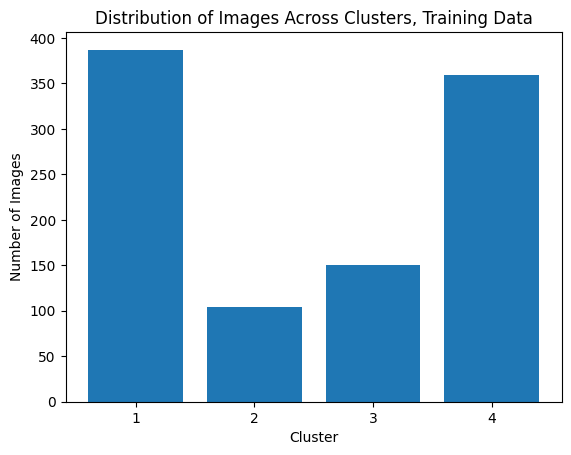

Cluster 4: 359 images
Cluster 1: 387 images
Cluster 2: 104 images
Cluster 3: 150 images


In [ ]:
plt.hist(labels, bins=range(5), align='left', rwidth=0.8)
plt.xlabel('Cluster')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Clusters, Training Data')
plt.xticks(range(4), [str(i+1) for i in range(4)])  # Adjust the x-axis labels
plt.show()

# Count the occurrences of each label
label_counts = Counter(labels)

# Print the counts for each cluster
for cluster, count in label_counts.items():
    print(f"Cluster {cluster + 1}: {count} images")

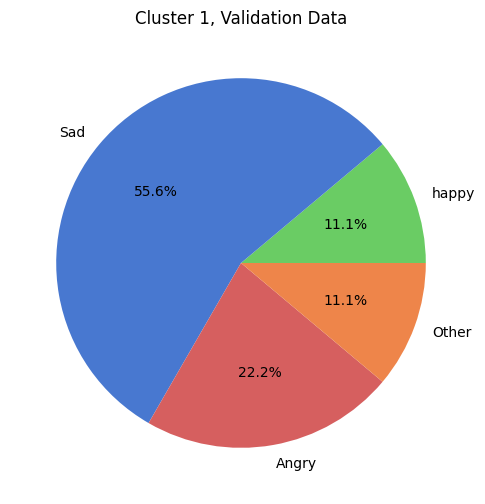

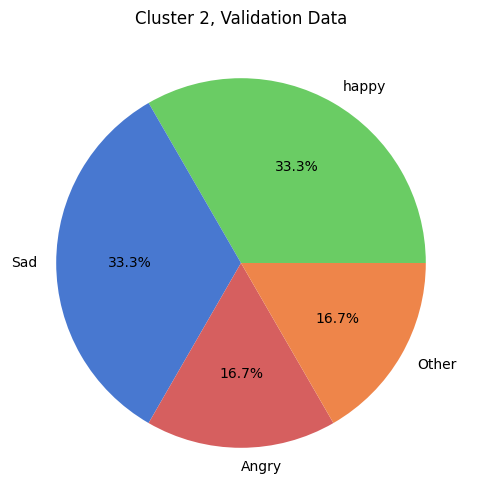

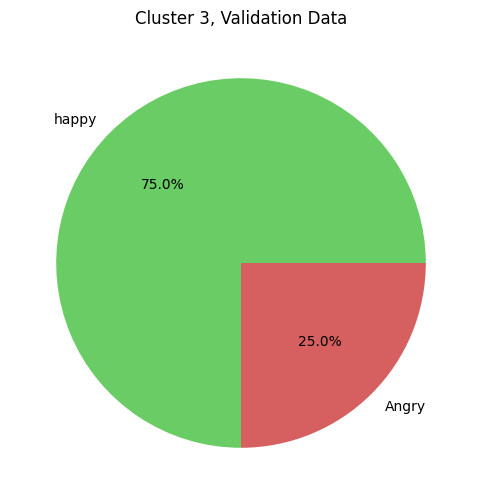

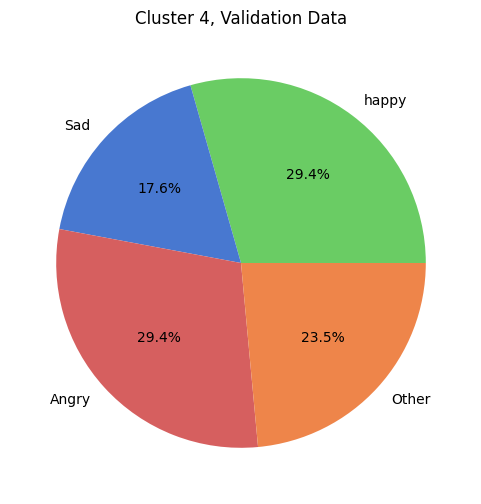

In [112]:
# Assuming you have the original emotion labels for the validation set
original_emotion_labels_validation = []
for emotion in emotion_folders:
    original_emotion_labels_validation.extend([emotion] * len(normalized_images_dict['valid'][emotion]))

# Assuming the labels for the validation set have been obtained
validation_labels = kmeans_resnet.predict(extracted_features_valid_array_resnet.reshape(extracted_features_valid_array_resnet.shape[0], -1))

# Create a list to hold the emotion count for each validation cluster
validation_clusters_data = [Counter() for _ in range(4)] # Assuming 4 clusters

# Count the emotions for each validation cluster using the validation cluster labels and original validation emotion labels
for cluster_label, original_emotion in zip(validation_labels, original_emotion_labels_validation):
    validation_clusters_data[cluster_label][original_emotion] += 1

# Pie graphs for validation data
for i, cluster in enumerate(validation_clusters_data):
    plt.figure(figsize=(6, 6))
    emotions, counts = zip(*cluster.items())
    colors = [color_map[e] for e in emotions]
    plt.pie(counts, labels=emotions, colors=colors, autopct='%1.1f%%')
    plt.title(f'Cluster {i + 1}, Validation Data') # Adjust the cluster number here
    plt.show()

Above, we again plot bar graphs showing the sizes of the clusters from another kmeans model with n = 4, and pie graphs showing the purity of each cluster in terms of percentage of emotion. This method did give one fairly pure cluster (3 at 75% happy), but cluster sizes are again not uniform. We will evaluate this model in our results and analysis section below.


### Model Approach 2: Custom CNN

Our second approach is to create a custom CNN from the training data that will give a probability distribution of what emotion a given image belongs to that we can then evaluate by comparing to our original emotion labels. We create this model in the code below: "

In [122]:
# Extract training images and labels
train_images = []
train_labels = []

emotion_mapping = {'happy': 0, 'Sad': 1, 'Angry': 2, 'Other': 3}

for emotion, images in normalized_images_dict['train'].items():
    train_images.extend(images)
    train_labels.extend([emotion_mapping[emotion]] * len(images))

train_images = np.array(train_images)
train_labels = to_categorical(np.array(train_labels), num_classes=4)

# Create a sequential model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the results
model.add(Flatten())

# Add a dense layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer with softmax activation for 4 emotion categories
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

# Extract validation images and labels
valid_images = []
valid_labels = []

for emotion, images in normalized_images_dict['valid'].items():
    valid_images.extend(images)
    valid_labels.extend([emotion_mapping[emotion]] * len(images))

valid_images = np.array(valid_images)
valid_labels = to_categorical(np.array(valid_labels), num_classes=4)

# Train the model with validation data
history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(valid_images, valid_labels))

# Train the model
#history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_split=0.2)

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_189 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_119 (MaxPooli  (None, 111, 111, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_190 (Conv2D)         (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_120 (MaxPooli  (None, 54, 54, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_191 (Conv2D)         (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_121 (MaxPooli  (None, 26, 26, 128)    

This is a brief description of the model we created above and justification for the design choices:

1. Sequential Model: A sequential model was chosen for its simplicity as the network has a linear stack of layers, suitable for our classification problem.

2. Convolutional Layers: Three convolutional layers with 32, 64, and 128 filters were used. They extract spatial features and hierarchical patterns from the images. The 3x3 kernel size is common and balances computational efficiency with the ability to capture essential features.

3. Pooling Layers: MaxPooling layers were added after each convolutional layer to reduce the dimensionality, capturing the dominant features and making the model less prone to overfitting.

4. Flatten Layer: This layer reshapes the multidimensional convolutional output into a flat vector, so it can be fed into the dense layers.

5. Dense Layer: A dense layer with 128 units and ReLU activation was added to interpret the features extracted by the convolutional layers, providing a level of abstraction.

6. Dropout Layer: A dropout layer with a rate of 0.5 was used to randomly set a fraction of the input units to 0 during training, which helps prevent overfitting.

7. Output Layer: The final dense layer with four units corresponds to the four emotion categories, and the softmax activation ensures the output is a probability distribution.

8. Loss and Optimization: Categorical cross-entropy was chosen as the loss function since this is a multi-class classification problem, and the Adam optimizer was selected for its adaptability and efficiency.

Below, we plot the loss and accuracy for each epoch to monitor for overfitting:




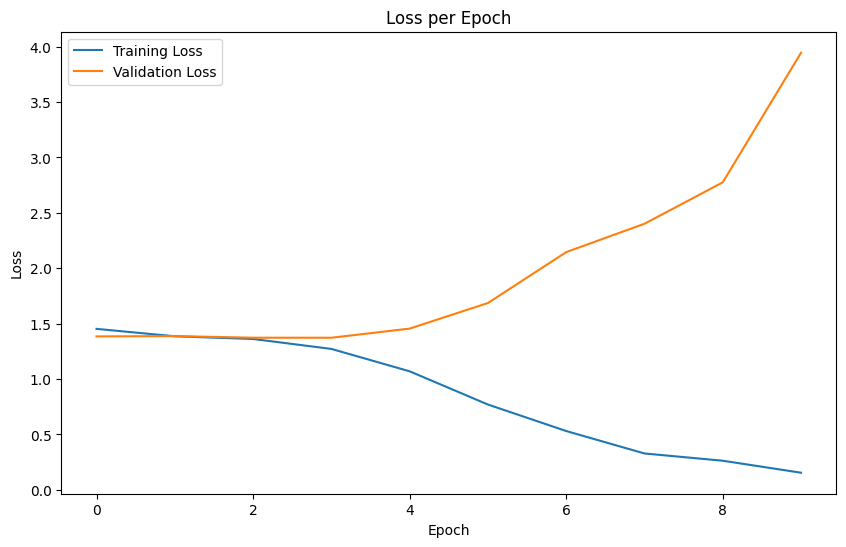

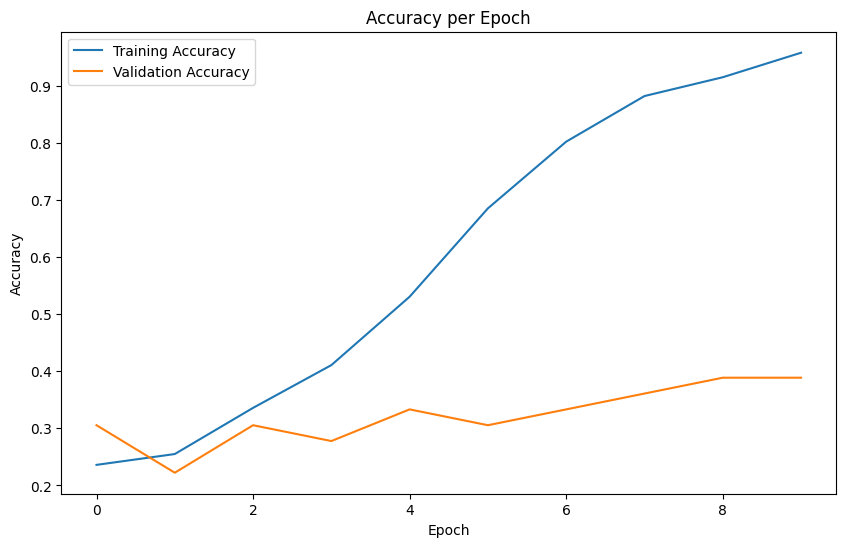

In [123]:
# Plot for Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot for Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

These plots show clear signs of overfitting on our model, with decreasing training loss and increasing training accuracy but increasing validation loss and low validation accuracy.

#### _Increasing Model Complexity and Hyperparameter Optimization Attempt_

Below, we create a second CNN model with added layers of complexity (with the format of $[Conv-Conv-MaxPool]_n$), use the PreLu activation function, institute batch normalization between layers, and introduce early stopping, so that if validation loss ever decreases between epochs, we stop the network and restore the best weights that give the best accuracy, as validation loss will only continue to increase after a certain point; the overall goal is attempting to minimize overfitting.  This code was tested and re-tested with different inputs for the various hyperparameters and architectural details of our model, and below is our best attempt to minimize performance on the validation set. Our model is below:

In [128]:
# Create a sequential model
model2 = Sequential()

n = 3  # number of (Conv-Conv-Maxpool) repetitions

# Add first convolutional layer with BatchNormalization and input shape
model2.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model2.add(PReLU())
model2.add(BatchNormalization())

for _ in range(n-1):
    # Add convolutional layer
    model2.add(Conv2D(32, (3, 3)))
    model2.add(PReLU())
    model2.add(BatchNormalization())

    model2.add(Conv2D(64, (3, 3)))
    model2.add(PReLU())
    model2.add(BatchNormalization())

    model2.add(MaxPooling2D((2, 2)))

# Flatten the results
model2.add(Flatten())

# Add a dense layer with BatchNormalization
model2.add(Dense(128))
model2.add(PReLU())
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

# Output layer with softmax activation for 4 emotion categories
model2.add(Dense(4, activation='softmax'))

# Compile the model with an initial learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model2.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model2.summary()

# Extract validation images and labels
valid_images = []
valid_labels = []

for emotion, images in normalized_images_dict['valid'].items():
    valid_images.extend(images)
    valid_labels.extend([emotion_mapping[emotion]] * len(images))

valid_images = np.array(valid_images)
valid_labels = to_categorical(np.array(valid_labels), num_classes=4)

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model with validation data and EarlyStopping
history = model2.fit(train_images, train_labels, epochs=10, batch_size=32,
                    validation_data=(valid_images, valid_labels),
                    callbacks=[early_stopping])

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_207 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 p_re_lu_117 (PReLU)         (None, 222, 222, 32)      1577088   
                                                                 
 batch_normalization_145 (Ba  (None, 222, 222, 32)     128       
 tchNormalization)                                               
                                                                 
 conv2d_208 (Conv2D)         (None, 220, 220, 32)      9248      
                                                                 
 p_re_lu_118 (PReLU)         (None, 220, 220, 32)      1548800   
                                                                 
 batch_normalization_146 (Ba  (None, 220, 220, 32)     128       
 tchNormalization)                                   

We can see above that after epoch 2, validation loss continues to increase even after learning rate is being decreased, and unfortunately we do not achieve any validation accuracy higher than 0.2778, lower than our baseline model. This updated model still shows significant overfitting.

Below we plot loss and accuracy for the training epochs as before:

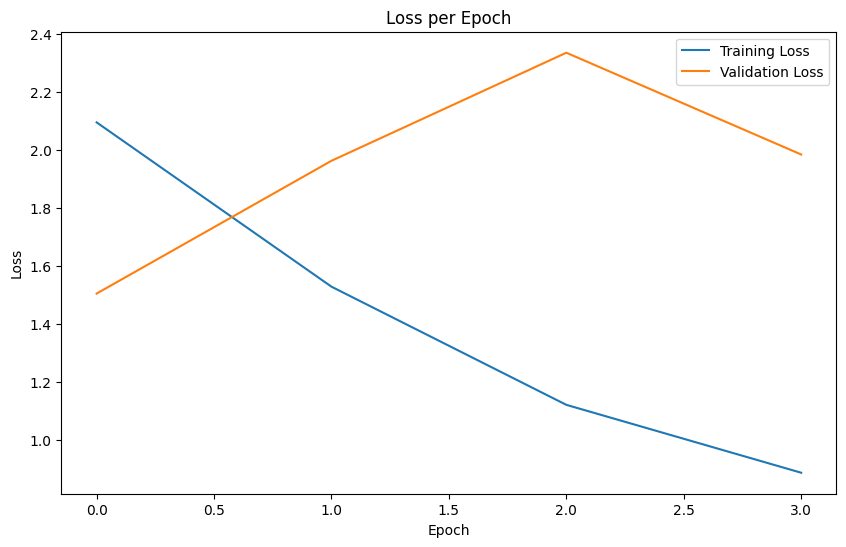

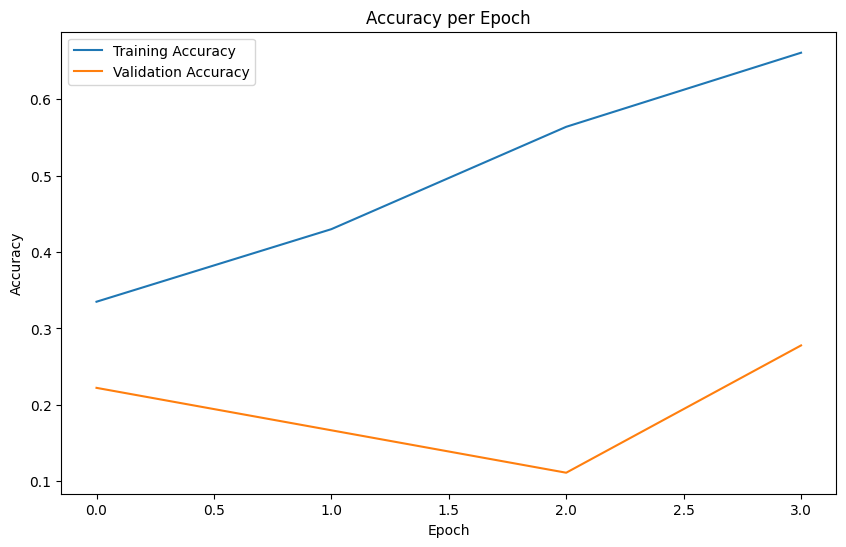

In [129]:
# Plot for Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot for Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

These plots corroborate that generalization error increases after epoch 2, while accuracy of validation remains low and reveals signs of overfitting. We will evaluate this model and our baseline model on unseen test data in the results and analysis section.


## Results and Analysis

### Evaluation on Test Data

#### Kmeans from MobileNet Model:






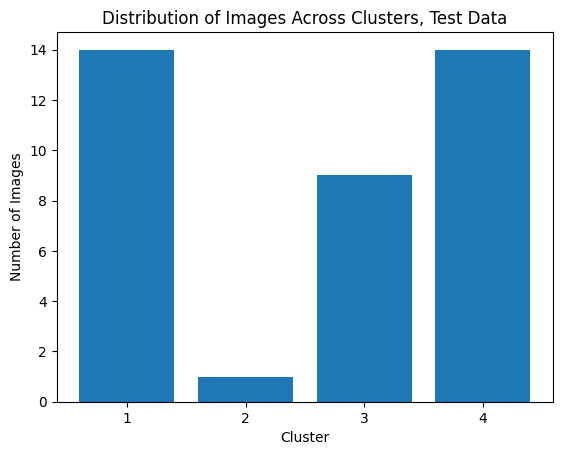

Cluster 3: 9 images
Cluster 4: 14 images
Cluster 1: 14 images
Cluster 2: 1 images


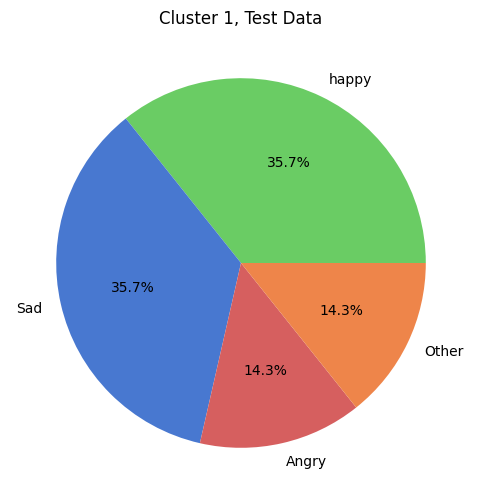

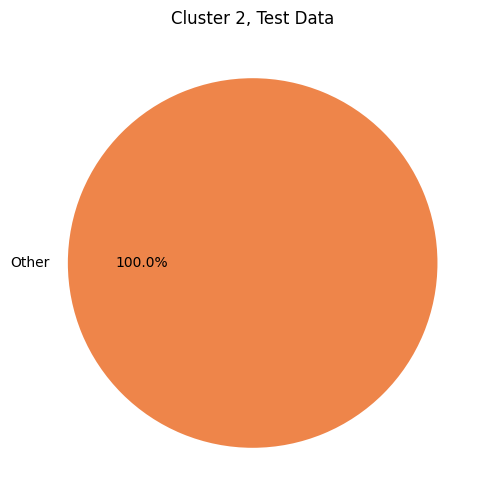

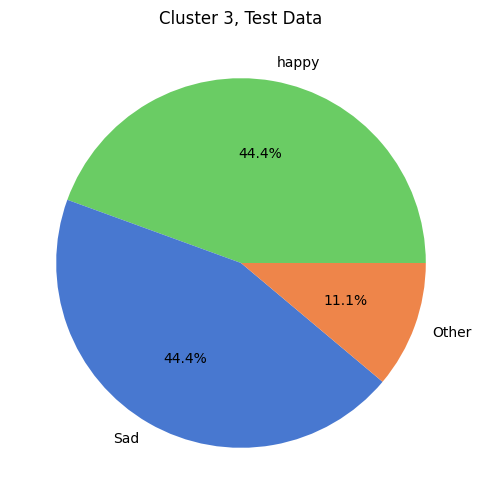

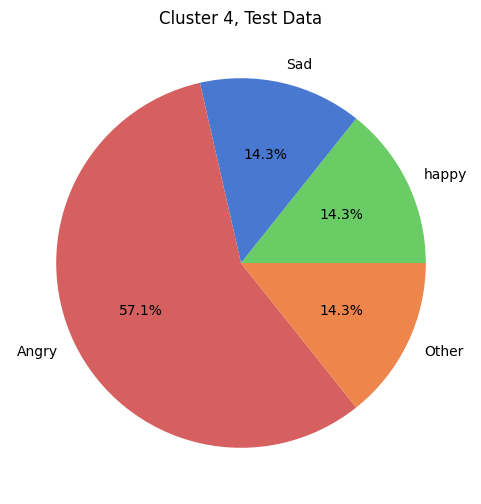

In [113]:
# Test Data Bar Chars and Pie Graphs for MobileNet K-Means

plt.hist(test_labels, bins=range(5), align='left', rwidth=0.8)
plt.xlabel('Cluster')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Clusters, Test Data')
plt.xticks(range(4), [str(i+1) for i in range(4)])  # Adjust the x-axis labels
plt.show()

# Count the occurrences of each label in the test set
test_label_counts = Counter(test_labels)

# Print the counts for each cluster
for cluster, count in test_label_counts.items():
    print(f"Cluster {cluster + 1}: {count} images")


# Assuming you have the original emotion labels for the test set
original_emotion_labels_test = []
for emotion in emotion_folders:
    original_emotion_labels_test.extend([emotion] * len(normalized_images_dict['test'][emotion]))

# Assuming the labels for the test set have been obtained
test_labels = kmeans.predict(extracted_features_test_array.reshape(extracted_features_test_array.shape[0], -1))

# Create a list to hold the emotion count for each test cluster
test_clusters_data = [Counter() for _ in range(4)] # Assuming 4 clusters

# Count the emotions for each test cluster using the test cluster labels and original test emotion labels
for cluster_label, original_emotion in zip(test_labels, original_emotion_labels_test):
    test_clusters_data[cluster_label][original_emotion] += 1

# Pie graphs for test data
for i, cluster in enumerate(test_clusters_data):
    plt.figure(figsize=(6, 6))
    emotions, counts = zip(*cluster.items())
    colors = [color_map[e] for e in emotions]
    plt.pie(counts, labels=emotions, colors=colors, autopct='%1.1f%%')
    plt.title(f'Cluster {i + 1}, Test Data') # Adjust the cluster number here
    plt.show()

Above, we visualize the cluster sizes and the purity of the clusters in terms of emotion for our test data on our kmeans model that we generated from feature extraction with MobileNet transfer learning. Again, we cannot generate an accuracy score because k-means is an unsupervised method, and doesn't know which images belong to which cluster. We can say that this baseline model was quite unsuccessful at creating clusters that correspond to the four types of emotions designated within the dataset. Though cluster 2 is the most pure, it only contains one single entry, and is therefore not useful at all. Cluster 4 shows closer what we would expect in terms of purity percentages if the algorithm were useful, with one majority emotion (Anger in this case) dominating the cluster and with other smaller percentages for the other clusters that were "misclassified" by the algorithm. Clusters 1 and 3 both have equal amounts of data of "happy" and "sad" images, so our algorithm clearly cannot distinguish between these very well, but finds these emotions more similar than different, and it clearly has a difficult time classifying any image labeled as "Other" into a category with additional "Other" images.

### Kmeans ResNet Model:

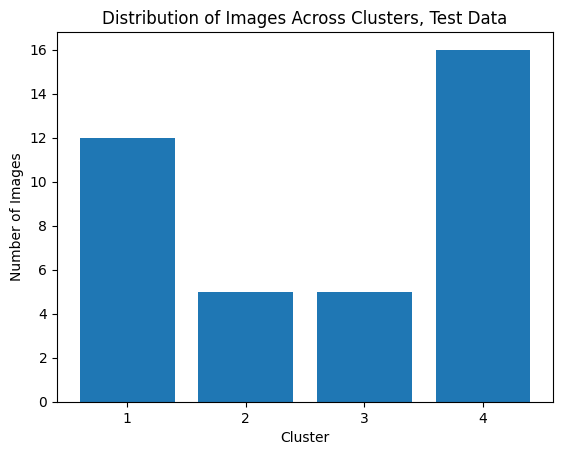

Cluster 4: 16 images
Cluster 2: 5 images
Cluster 1: 12 images
Cluster 3: 5 images


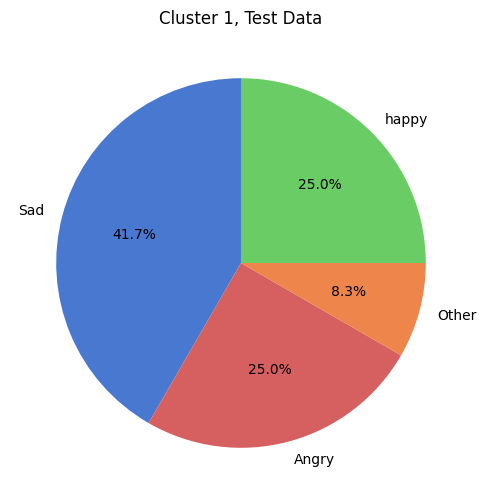

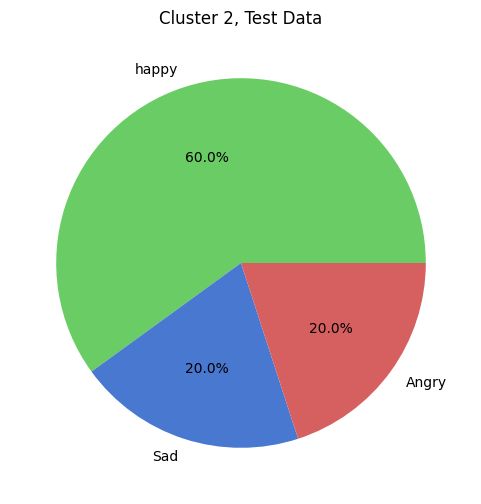

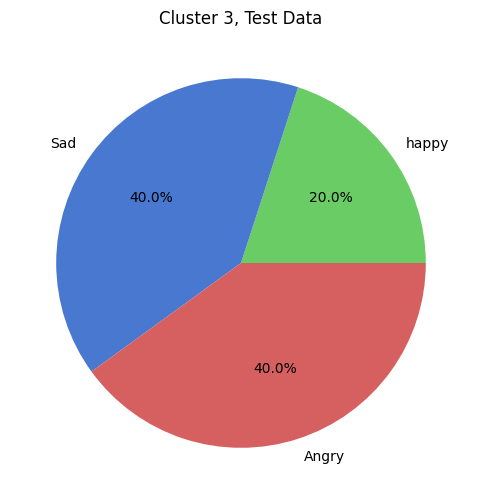

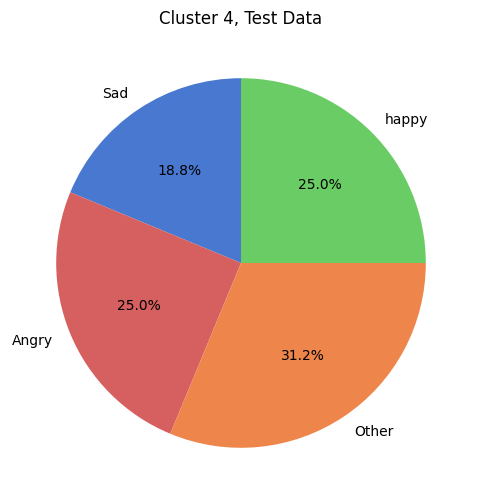

In [120]:
# Test Data Bar Chars and Pie Graphs for MobileNet K-Means

plt.hist(test_labels_resnet, bins=range(5), align='left', rwidth=0.8)
plt.xlabel('Cluster')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Clusters, Test Data')
plt.xticks(range(4), [str(i+1) for i in range(4)])  # Adjust the x-axis labels
plt.show()

# Count the occurrences of each label in the test set
test_label_counts = Counter(test_labels_resnet)

# Print the counts for each cluster
for cluster, count in test_label_counts.items():
    print(f"Cluster {cluster + 1}: {count} images")


# Assuming you have the original emotion labels for the test set
original_emotion_labels_test = []
for emotion in emotion_folders:
    original_emotion_labels_test.extend([emotion] * len(normalized_images_dict['test'][emotion]))

# Assuming the labels for the test set have been obtained
test_labels_resnet = kmeans_resnet.predict(extracted_features_test_array_resnet.reshape(extracted_features_test_array_resnet.shape[0], -1))

# Create a list to hold the emotion count for each test cluster
test_clusters_data = [Counter() for _ in range(4)] # Assuming 4 clusters

# Count the emotions for each test cluster using the test cluster labels and original test emotion labels
for cluster_label, original_emotion in zip(test_labels_resnet, original_emotion_labels_test):
    test_clusters_data[cluster_label][original_emotion] += 1

# Pie graphs for test data
for i, cluster in enumerate(test_clusters_data):
    plt.figure(figsize=(6, 6))
    emotions, counts = zip(*cluster.items())
    colors = [color_map[e] for e in emotions]
    plt.pie(counts, labels=emotions, colors=colors, autopct='%1.1f%%')
    plt.title(f'Cluster {i + 1}, Test Data') # Adjust the cluster number here
    plt.show()

We attempted another kmeans clustering approach, but by using ResNet50 transfer learning to extract features from the image data, in the hopes that this model would be able to extract features that could be clustered together better in terms of emotions from the original data. Unfortunately, the visualizations above reveal that this model also performed poorly. We only have one cluster (2) that shows any significant purity (happy being dominant at 60% of the cluster), but this cluster is also undersized at only 5 images (the test image folder has 38 images, and 11 were classified as "happy"). Clusters 1 and 4 both have a top percentage that is more abundant than all others, but it is not the majority emotion in either cluster. Cluster 3 has equal amounts of sad and angry images, so the algorithm did poorly at distinguishing between these two emotions in this cluster.

Overall, k-means clustering of extracted feature data that was procured from transfer learning models was largely unable to separate images cleanly based upon the displayed pet emotion.

#### CNN Initial Model:

In [124]:
# Extract test images and labels
test_images = []
test_labels = []

for emotion, images in normalized_images_dict['test'].items():
    test_images.extend(images)
    test_labels.extend([emotion_mapping[emotion]] * len(images))

test_images = np.array(test_images)
test_labels = to_categorical(np.array(test_labels), num_classes=4)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_accuracy*100:.2f}%")

2/2 [==============================] - 0s 33ms/step - loss: 5.7686 - accuracy: 0.3684
Test accuracy: 36.84%


Our initial model accuracy was 36.84% - the rate at which it correctly classified test image data into their correct emotion.

We visualize the results below with a confusion matrix and heatmap:

2/2 [==============================] - 0s 63ms/step
Confusion Matrix:
[[4 4 1 2]
 [4 3 2 2]
 [1 3 5 1]
 [1 1 2 2]]


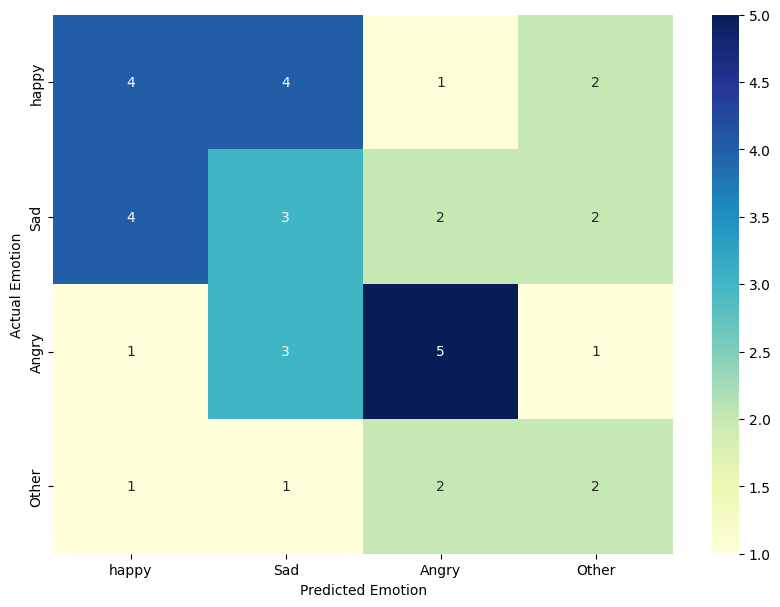

In [132]:
from sklearn.metrics import confusion_matrix

# Get the predicted probabilities
predicted_probs = model.predict(test_images)

# Convert probabilities to class labels
predicted_labels = np.argmax(predicted_probs, axis=1)

# Convert one-hot encoded test labels back to class labels
true_labels = np.argmax(test_labels, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define emotion labels for the confusion matrix
emotion_labels = [emotion for emotion, _ in sorted(emotion_mapping.items(), key=lambda x: x[1])]

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, cmap="YlGnBu", xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted Emotion')
plt.ylabel('Actual Emotion')
plt.show()

Our model correctly classified angry the most, and was quite poor at classifying any images with an "Other" emotion. Overall, it was not very good at classification, misclassifying most of the images into the incorrect categories.

#### More Complex CNN:

In [130]:

# Evaluate the model on the test data
test_loss, test_accuracy = model2.evaluate(test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_accuracy*100:.2f}%")

2/2 [==============================] - 0s 98ms/step - loss: 1.5050 - accuracy: 0.1579
Test accuracy: 15.79%


We see a remarkably worse performance on the test data with model 2. We again use a confusion matrix and a heatmap to visualize results below:

2/2 [==============================] - 1s 356ms/step
Confusion Matrix:
[[5 0 1 5]
 [9 0 0 2]
 [5 0 0 5]
 [5 0 0 1]]


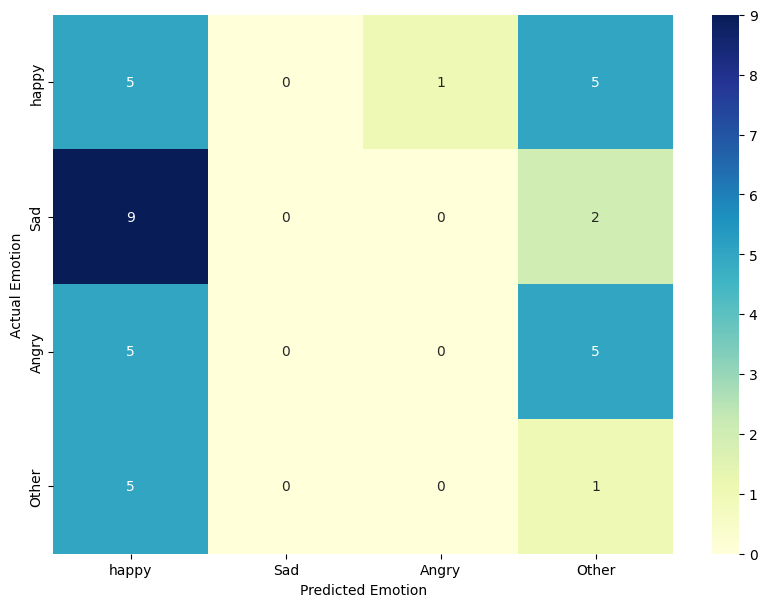

In [133]:
# Get the predicted probabilities
predicted_probs = model2.predict(test_images)

# Convert probabilities to class labels
predicted_labels = np.argmax(predicted_probs, axis=1)

# Convert one-hot encoded test labels back to class labels
true_labels = np.argmax(test_labels, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define emotion labels for the confusion matrix
emotion_labels = [emotion for emotion, _ in sorted(emotion_mapping.items(), key=lambda x: x[1])]

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, cmap="YlGnBu", xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted Emotion')
plt.ylabel('Actual Emotion')
plt.show()

This model couldn't identify any images as sad, and only one image as angry (misclassified). It only correctly classified 6 images. The "improvements" we made to our initial model were clearly superfluous, unable to come close to the performance of the initial model.

### Summary of Results and Analysis

The experiment conducted involved two different techniques to classify images based on four types of emotions: k-means clustering with feature extraction through MobileNet and ResNet50 transfer learning, and two Convolutional Neural Network (CNN) models.

1. K-Means Clustering with MobileNet and ResNet50:

 - The k-means clustering approach using MobileNet was largely unsuccessful in creating meaningful clusters corresponding to the different emotions. Some clusters had equal amounts of "happy" and "sad" images, and the classification of "Other" was particularly problematic. One cluster was pure but contained only a single entry.
 - Applying k-means clustering with features extracted from ResNet50 also led to poor results. One cluster showed significant purity (60%) with "happy" images, but was undersized. Other clusters failed to achieve majority emotions, and the distinction between "sad" and "angry" was poor.
 - The conclusion for k-means clustering is that it was largely ineffective at separating images based on displayed emotions.

2. CNN Initial Model:

 - The initial CNN model yielded an accuracy rate of 36.84%, with the best classification performance for "angry" images.
 - The model was poor at classifying the "Other" emotion and misclassified most images into incorrect categories.
 - A confusion matrix and heatmap provided visual insights into the misclassifications.

3. More Complex CNN:

 - The second, more complex CNN model performed even worse than the initial model, failing to identify any images as "sad" and only misclassifying one image as "angry."
 - The model correctly classified only 6 images, and the so-called improvements made to the initial model were deemed superfluous and detrimental.

In summary, both the k-means clustering techniques using MobileNet and ResNet50 and the CNN models were not effective in classifying images according to the four designated emotions. The initial CNN model's performance was modest, but the subsequent models and techniques demonstrated poor and inconsistent results, underscoring the challenge of emotion classification in the given dataset.

## Discussion and Conclusions

Our attempts to classify images of pet emotions using transfer learning (for feature extraction) followed by k-means clustering, and subsequent training with a Convolutional Neural Network (CNN) model, were, unfortunately, disappointing and largely ineffective.

The failure of the k-means algorithm is somewhat understandable, as it's an unsupervised method that relies on distance similarity metrics without any direct consideration of emotion. It does not have an accuracy metric by which to gauge performance, making it conceivable that even similar images could be divided into emotionally dissimilar clusters. The transfer learning algorithms (MobileNet and ResNet50) may not have been specifically designed for this task, which could have contributed to the failure.

While we expected better performance from our CNN models, the best we could achieve was less than 37% accuracy on unseen data. The fact that a more complex model performed even worse than a simpler one may reveal underlying issues with the dataset itself.

I argue that a CNN may struggle to accurately classify emotions across different species, as animals display emotions with varied facial characteristics. Additionally, the given emotion labels in the dataset appear highly subjective, as emotions in animals are often displayed differently (e.g., through tail movements in dogs). The subjectivity of human judgment contrasts sharply with the mathematical precision required by a computer program.

Upon further examination of the dataset (random images are printed out below again, for convenience), inconsistencies in the labeling process become evident. The lack of clarity on how the images were originally labeled in the Kaggle dataset further complicates the issue. If I were to revisit this project, I might consider an alternative approach to labeling, such as performing k-means clustering first and then assigning emotions to clusters.

In conclusion, while our chosen methods were ineffective at identifying pet emotions, it is likely that pre-existing problems with the dataset contributed to these failures. This complex issue would benefit from a deeper analysis, potentially involving collaboration between experts in machine learning and animal behavior, to draw more meaningful conclusions.

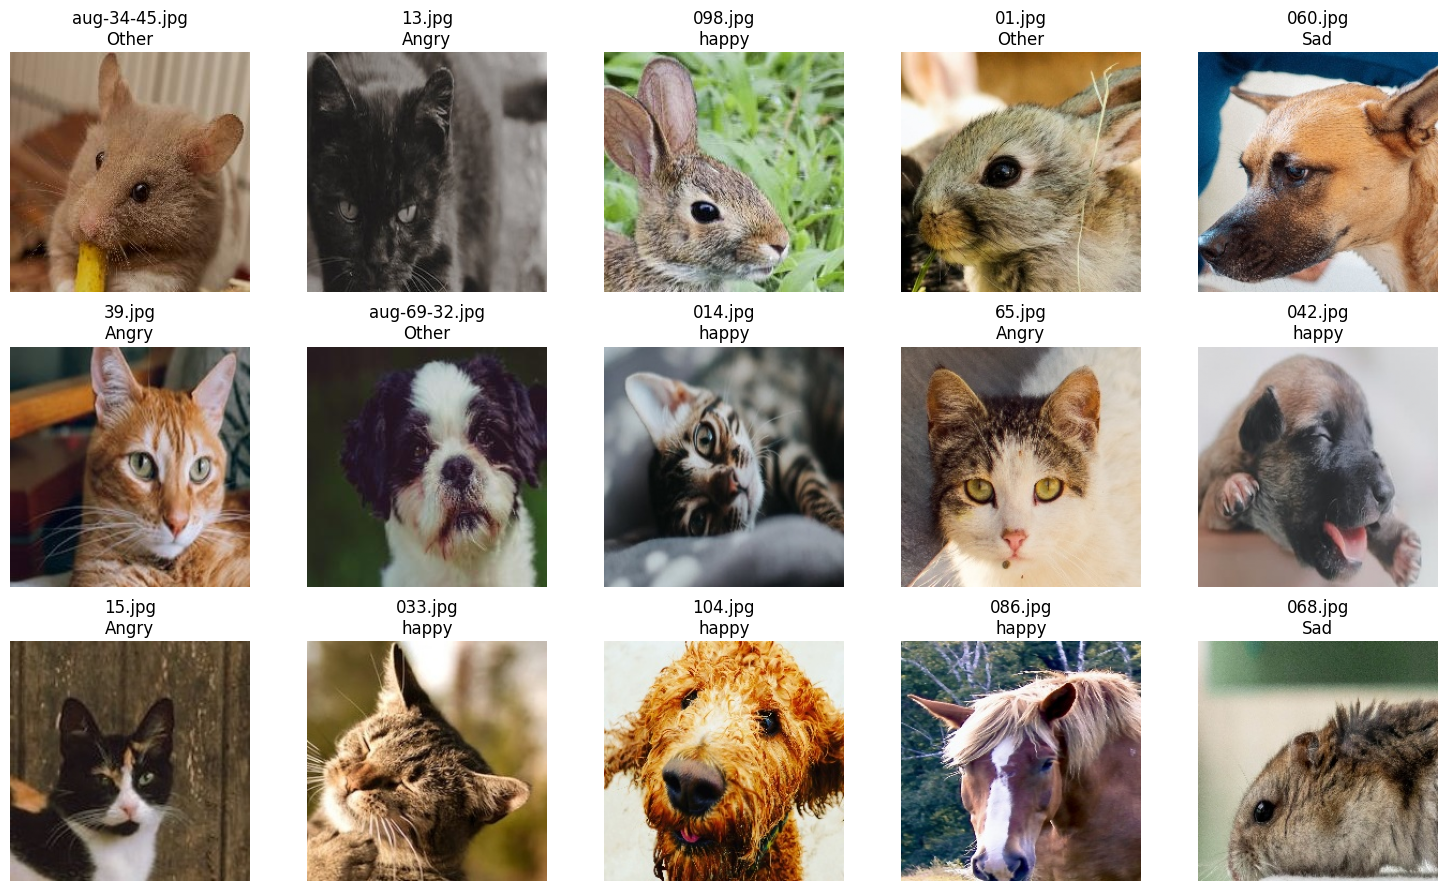

In [134]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
displayed_images = set() # To keep track of the images we've already displayed

for ax in axes.flat:
    folder, emotion, image_index = None, None, None

    # Ensure that the selected image has not been displayed before
    while True:
        folder = random.choice(main_folders)
        emotion = random.choice(emotion_folders)
        image_index = random.randint(0, len(normalized_images_dict[folder][emotion]) - 1)

        unique_key = (folder, emotion, image_index)
        if unique_key not in displayed_images:
            displayed_images.add(unique_key)
            break

    image = normalized_images_dict[folder][emotion][image_index]
    filename = os.listdir(os.path.join(base_path, folder, emotion))[image_index]

    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"{filename}\n{emotion}")

plt.tight_layout()
plt.show()